In [57]:
import numpy as np
import random
from scipy.optimize import minimize, linear_sum_assignment
import itertools
import matplotlib.pyplot as plt

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Player dictionary
First, preferences - score out of 10 for which positions are preferred.
**TODO: Should I enforce that scores sum to 10?**

In [41]:
# new preference positions - now with sides

all_players = dict()

# preferred positions
all_players['jen'] = [('G', 5), ('D',0), ('DCM', 0), ('LW',0), ('RW', 0), ('ACM',0)]
all_players['etsuko'] = [('G', 5), ('D',0), ('DCM', 0), ('LW',0), ('RW', 0), ('ACM',0)]
all_players['danni'] = [('G', 5), ('D',0), ('DCM', 0), ('LW',0), ('RW', 0), ('ACM',0)]

all_players['jazzie'] = [('G', 1), ('D',5), ('DCM', 3), ('LW',2), ('RW', 2), ('ACM',1)]
all_players['helen'] = [('G', 1), ('D', 5), ('DCM',2), ('LW',3), ('RW', 4), ('ACM',1)]
all_players['sian'] = [('G', 0), ('D',4), ('DCM',0), ('LW',4), ('RW', 4), ('ACM',1)]
all_players['vicky'] = [('G', 3), ('D',0), ('DCM',4), ('LW',2), ('RW', 3), ('ACM',4)]
all_players['keah'] = [('G', 1), ('D',1), ('DCM',3), ('LW',5), ('RW', 4), ('ACM',2)]
all_players['shafa'] = [('G', 1), ('D',3), ('DCM',3), ('LW',3), ('RW', 4), ('ACM',5)]
all_players['jaz'] = [('G', 1), ('D',2), ('DCM',1), ('LW',5), ('RW', 4), ('ACM',3)]
all_players['ella'] = [('G', 0), ('D',0), ('DCM',2), ('LW',3), ('RW', 3), ('ACM',5)]
all_players['samira'] = [('G', 0), ('D',0), ('DCM',2), ('LW',3), ('RW', 3), ('ACM',5)]
all_players['olivia'] = [('G', 0), ('D',0), ('DCM',5), ('LW',3), ('RW', 3), ('ACM',2)]
all_players['connie'] = [('G', 0), ('D',1), ('DCM',4), ('LW',4), ('RW', 2), ('ACM',0)]
all_players['roisin'] = [('G', 0), ('D',4), ('DCM',2), ('LW',0), ('RW', 0), ('ACM',0)]
all_players['kiyanne'] = [('G', 0), ('D',0), ('DCM',3), ('LW',3), ('RW', 3), ('ACM',3)]



player_costs = dict()

for player in all_players.keys():
    prefs = all_players[player]

    weights = []
    sum_weights = sum(w for pos, w in prefs)
    for x in prefs:
        weight = 1-(x[1]/sum_weights) if x[1]!=0 else 1.0
        weights.append((x[0], weight))
        
    player_costs[player] = weights
    
print(player_costs)

{'jen': [('G', 0.0), ('D', 1.0), ('DCM', 1.0), ('LW', 1.0), ('RW', 1.0), ('ACM', 1.0)], 'etsuko': [('G', 0.0), ('D', 1.0), ('DCM', 1.0), ('LW', 1.0), ('RW', 1.0), ('ACM', 1.0)], 'danni': [('G', 0.0), ('D', 1.0), ('DCM', 1.0), ('LW', 1.0), ('RW', 1.0), ('ACM', 1.0)], 'jazzie': [('G', 0.9285714285714286), ('D', 0.6428571428571428), ('DCM', 0.7857142857142857), ('LW', 0.8571428571428572), ('RW', 0.8571428571428572), ('ACM', 0.9285714285714286)], 'helen': [('G', 0.9375), ('D', 0.6875), ('DCM', 0.875), ('LW', 0.8125), ('RW', 0.75), ('ACM', 0.9375)], 'sian': [('G', 1.0), ('D', 0.6923076923076923), ('DCM', 1.0), ('LW', 0.6923076923076923), ('RW', 0.6923076923076923), ('ACM', 0.9230769230769231)], 'vicky': [('G', 0.8125), ('D', 1.0), ('DCM', 0.75), ('LW', 0.875), ('RW', 0.8125), ('ACM', 0.75)], 'keah': [('G', 0.9375), ('D', 0.9375), ('DCM', 0.8125), ('LW', 0.6875), ('RW', 0.75), ('ACM', 0.875)], 'shafa': [('G', 0.9473684210526316), ('D', 0.8421052631578947), ('DCM', 0.8421052631578947), ('LW',

# array format: [defender, central, winger, forward]

all_players = dict()

# preferred positions
all_players['jazzie'] = [('D',10), ('C',0), ('W',0), ('F',0)]
all_players['caroline'] = [('D',10), ('C',0), ('W',0), ('F',0)]
all_players['helen'] = [('D', 8), ('C',0), ('W',2), ('F',0)]
all_players['christine'] = [('D',0), ('C',0), ('W',2), ('F',8)]
all_players['sian'] = [('D',5), ('C',0), ('W',5), ('F',0)]
all_players['vicky'] = [('D',0), ('C',6), ('W',3), ('F',1)]
all_players['keah'] = [('D',0), ('C',3), ('W',5), ('F',2)]
all_players['shafa'] = [('D',4), ('C',0), ('W',3), ('F',7)]
all_players['olivia'] = [('D',10), ('C',0), ('W',0), ('F',0)]
all_players['mychelle'] = [('D',0), ('C',6), ('W',0), ('F',3)]
all_players['jaz'] = [('D',0), ('C',2), ('W',8), ('F',0)]

#convert preferences to costs
player_costs = dict()

for player in all_players.keys():
    prefs = all_players[player]

    weights = []
    for x in prefs:
        weight = 1-(x[1]/10) if x[1]!=0 else 1.0
        weights.append((x[0], weight))
        
    player_costs[player] = weights

## Helper functions

In [42]:
def get_this_week_player_costs(this_week, player_costs=player_costs):
    this_week_player_costs = dict()
    for player in this_week:
        this_week_player_costs[player] = player_costs[player]
    return this_week_player_costs

def dict_to_cost_matrix(player_costs, formation):
    cost_matrix = []
    for player in player_costs:
        cost_list = []
        for position in formation:
            for x in player_costs[player]:
                if x[0]==position:
                    cost_list.append(x[1])
        cost_matrix.append(cost_list)
    
    return np.array(cost_matrix)

def append_subs_to_cost_matrix(cost_matrix, subs_weights):
    n_subs = len(cost_matrix) - 7
    cost_matrix_with_subs = []
    for i in range(len(cost_matrix)):
        cost_list = list(cost_matrix[i])
        for j in range(n_subs):
            cost_list.append(subs_weights[i])
        cost_matrix_with_subs.append(cost_list)
    return np.array(cost_matrix_with_subs)

def alter_subs_weights(cost_matrix, subs_weights):
    # todo: make sure that goalie have additional sub weight
    n_subs = len(cost_matrix) - 7
    cost_matrix_with_subs = []
    for i in range(len(cost_matrix)):
        cost_list = list(cost_matrix[i])
        for j in range(n_subs):
            cost_list[-(j+1)] = subs_weights[i]
        cost_matrix_with_subs.append(cost_list)
    return np.array(cost_matrix_with_subs)

def convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs):
    formation_dict = {'G':[], 'D':[], 'DCM':[], 'LW':[], 'RW':[], 'ACM':[], 'S':[]}
    for i in range(len(col_ind)):
        position = formation_with_subs[col_ind[i]]
        player = this_week[i]
        formation_dict[position].append(player)
    formation_dict['cost'] = cm[row_ind, col_ind].sum()
    return formation_dict

def convert_formation_to_list(formation_dict):
    #out_list = [['etsuko']]
    out_list = []
    #out_list = [['et']]
    out_list.append(formation_dict['G'])
    out_list.append(formation_dict['D'])
    out_list.append(formation_dict['DCM'])
    out_list.append(formation_dict['LW'])
    out_list.append(formation_dict['RW'])
    out_list.append(formation_dict['ACM'])
    out_list.append(formation_dict['S'])
    return list(np.concatenate(out_list).flat)

## Get players this week
**TODO: What happens without Etsuko?**

In [43]:
this_week = []

for player in all_players.keys():
    valid_entry = False
    
    while not valid_entry:
        entry = input(f'Is {player} playing this week (y/n)? ')
        if entry == 'y':
            this_week.append(player)
            break
        elif entry == 'n':
            break
        else:
            print('Invalid entry!')

n_players_this_week = len(this_week)
    
print(f"This week's squad: {this_week} ({n_players_this_week})")

Is jen playing this week (y/n)? n
Is etsuko playing this week (y/n)? 
Invalid entry!
Is etsuko playing this week (y/n)? n
Is danni playing this week (y/n)? y
Is jazzie playing this week (y/n)? y
Is helen playing this week (y/n)? y
Is sian playing this week (y/n)? y
Is vicky playing this week (y/n)? y
Is keah playing this week (y/n)? n
Is shafa playing this week (y/n)? n
Is jaz playing this week (y/n)? y
Is ella playing this week (y/n)? n
Is samira playing this week (y/n)? y
Is olivia playing this week (y/n)? y
Is connie playing this week (y/n)? n
Is roisin playing this week (y/n)? n
Is kiyanne playing this week (y/n)? y
This week's squad: ['danni', 'jazzie', 'helen', 'sian', 'vicky', 'jaz', 'samira', 'olivia', 'kiyanne'] (9)


## Set up formation and get costs

In [44]:
formation = ['G','D', 'D', 'DCM', 'LW', 'RW', 'ACM']
#formation = ['G','D', 'D', 'D', 'LW', 'RW', 'F']
formation_with_subs = formation.copy()
for i in range(n_players_this_week-7):
    formation_with_subs.append('S')

#random.shuffle(this_week)
this_week_player_costs = get_this_week_player_costs(this_week)
cm_no_subs = dict_to_cost_matrix(this_week_player_costs, formation)

## Set substitute weight

In [45]:
sub_weight = 5.0 # cost of previously-subbed player getting subbed again

n_repeats = 0
if n_players_this_week == 8:
    n_repeats = 7
elif n_players_this_week == 9:
    n_repeats = 4
elif n_players_this_week == 10:
    if 'etsuko' not in this_week and 'jen' not in this_week and 'dani' not in this_week:
        n_repeats = 6
    else:
        n_repeats = 3
        
print(n_repeats)

4


## Straight-up linear sum assignment

In [46]:
initial_subs_weights = np.zeros(n_players_this_week)

if 'etsuko' in this_week or 'jen' in this_week or 'dani' in this_week: #todo: is this fucked if I shuffle this_week? np.where to get index
    initial_subs_weights[0] = 500000

cm = append_subs_to_cost_matrix(cm_no_subs, initial_subs_weights)
    
subs_weights = initial_subs_weights.copy()
for i in range(n_repeats):
    row_ind, col_ind = linear_sum_assignment(cm)
    print(convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs))
    print(subs_weights)
    
    for i in range(len(row_ind)):
        if formation_with_subs[col_ind[i]]=='S':
            subs_weights[i] += sub_weight
    cm = alter_subs_weights(cm, subs_weights)

{'G': ['danni'], 'D': ['jazzie', 'helen'], 'DCM': ['olivia'], 'LW': ['jaz'], 'RW': ['sian'], 'ACM': ['samira'], 'S': ['vicky', 'kiyanne'], 'cost': 3.9409340659340657}
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
{'G': ['danni'], 'D': ['jazzie', 'helen'], 'DCM': ['olivia'], 'LW': ['kiyanne'], 'RW': ['vicky'], 'ACM': ['samira'], 'S': ['sian', 'jaz'], 'cost': 4.123626373626374}
[0. 0. 0. 0. 5. 0. 0. 0. 5.]
{'G': ['danni'], 'D': ['jazzie', 'sian'], 'DCM': ['vicky'], 'LW': ['jaz'], 'RW': ['kiyanne'], 'ACM': ['samira'], 'S': ['helen', 'olivia'], 'cost': 4.138049450549451}
[0. 0. 0. 5. 5. 5. 0. 0. 5.]
{'G': ['danni'], 'D': ['helen', 'sian'], 'DCM': ['olivia'], 'LW': ['jaz'], 'RW': ['kiyanne'], 'ACM': ['vicky'], 'S': ['jazzie', 'samira'], 'cost': 4.1826923076923075}
[0. 0. 5. 5. 5. 5. 0. 5. 5.]


In [47]:
def objective_function(x, cm_no_subs, n_repeats):
    
    vals = []
    
    cm = append_subs_to_cost_matrix(cm_no_subs, x)
    subs_weights = x.copy()
    
    for i in range(n_repeats):
        row_ind, col_ind = linear_sum_assignment(cm)
        formation_dict = convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs)
        vals.append(formation_dict['cost'])

        for i in range(len(row_ind)):
            if formation_with_subs[col_ind[i]]=='S':
                subs_weights[i] += 1.0
        cm = alter_subs_weights(cm, subs_weights)
    
    val = np.var(vals)
    #print(x, val)
    
    return val

In [48]:
bound = (0, 1)
bounds = []
for i in range(n_players_this_week):
    bounds.append(bound)
    
res = minimize(objective_function, x0=np.zeros(n_players_this_week), args=(cm_no_subs, n_repeats), bounds=bounds, method='SLSQP', options={'eps':0.1})
print(res)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.003064687945623306
       x: [ 4.443e-17  0.000e+00  6.939e-18  1.388e-17  5.895e-02
            7.835e-28  0.000e+00  1.453e-27  3.070e-02]
     nit: 2
     jac: [ 0.000e+00  5.073e-02  2.841e-02  2.577e-02 -1.380e-03
            4.354e-02  5.073e-02  5.073e-02  2.063e-03]
    nfev: 31
    njev: 2


In [49]:
initial_subs_weights = res.x
cm = append_subs_to_cost_matrix(cm_no_subs, initial_subs_weights)
    
subs_weights = initial_subs_weights.copy()

for_display = []
for i in range(n_repeats):
    row_ind, col_ind = linear_sum_assignment(cm)
    formation_dict = convert_lsa_output_to_formation(cm, row_ind, col_ind, this_week, formation_with_subs)
    print(formation_dict)
    for_display.append(convert_formation_to_list(formation_dict))
    
    for i in range(len(row_ind)):
        if formation_with_subs[col_ind[i]]=='S':
            subs_weights[i] += sub_weight
    cm = alter_subs_weights(cm, subs_weights)

{'G': ['danni'], 'D': ['jazzie', 'helen'], 'DCM': ['olivia'], 'LW': ['jaz'], 'RW': ['sian'], 'ACM': ['samira'], 'S': ['vicky', 'kiyanne'], 'cost': 4.030580357142799}
{'G': ['danni'], 'D': ['jazzie', 'helen'], 'DCM': ['olivia'], 'LW': ['kiyanne'], 'RW': ['vicky'], 'ACM': ['samira'], 'S': ['sian', 'jaz'], 'cost': 4.123626373626374}
{'G': ['danni'], 'D': ['jazzie', 'sian'], 'DCM': ['vicky'], 'LW': ['jaz'], 'RW': ['kiyanne'], 'ACM': ['samira'], 'S': ['helen', 'olivia'], 'cost': 4.138049450549451}
{'G': ['danni'], 'D': ['helen', 'sian'], 'DCM': ['olivia'], 'LW': ['jaz'], 'RW': ['kiyanne'], 'ACM': ['vicky'], 'S': ['jazzie', 'samira'], 'cost': 4.1826923076923075}


In [50]:
print(for_display)

[['danni', 'jazzie', 'helen', 'olivia', 'jaz', 'sian', 'samira', 'vicky', 'kiyanne'], ['danni', 'jazzie', 'helen', 'olivia', 'kiyanne', 'vicky', 'samira', 'sian', 'jaz'], ['danni', 'jazzie', 'sian', 'vicky', 'jaz', 'kiyanne', 'samira', 'helen', 'olivia'], ['danni', 'helen', 'sian', 'olivia', 'jaz', 'kiyanne', 'vicky', 'jazzie', 'samira']]


In [76]:
def plot_formation_321(formation, t_start, t_stop):
    # format for formation should be: GK, LB, CB, RB, LW, RW, CF, S, S, S
    make_pitch()
    
    positions_x = [2.5, 1, 2, 3, 1.5, 3.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 2.8, 2.8, 2.8, 1, 1, 0, 3, 2, 1]
    
    for i in range(len(formation)):
        plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')
    
    plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')
    
    plt.annotate(f'{t_start} - {t_stop} mins', (3.5, 5), color='white', fontsize=14, ha='center' )
    

def plot_formation(formation, t_start, t_stop):
    # format for formation should be: GK, LB, RB, DCM, LW, RW, ACM, S, S, S
    make_pitch()
    
    positions_x = [2.5, 1.5, 3.5, 2.5, 0.5, 4.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 3, 3, 1.8, 0, 0, 1, 3, 2, 1]
    
    for i in range(len(formation)):
        plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')
    
    plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')
    
    plt.annotate(f'{t_start} - {t_stop} mins', (3.5, 5), color='white', fontsize=14, ha='center' )
    
def make_pitch():
    plt.figure(figsize=[6,6])
    plt.xlim([-1, 8])
    plt.ylim([-1, 5.5])
    plt.hlines([4.5, -0.5], -0.5, 5.5, color='white' )
    plt.hlines(3.5, 1.5, 3.5, color='white')
    plt.vlines([-0.5, 5.5], -0.5, 4.5, color='white')
    plt.vlines([1.5, 3.5], 3.5, 4.5, color='white')

    plt.plot([2.5], [-0.5], 'o', ms=5, color='w')
    
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.set_facecolor('green')
    
    return ax

def make_pitches(n_repeats):
    fig, axs = plt.subplots(1, n_repeats, figsize = (6*n_repeats, 6))

    for ax in axs:
        ax.set_xlim([-1, 8])
        ax.set_ylim([-1, 5.5])
        ax.hlines([-0.5, 4.5], -0.5, 5.5, color='white')
        ax.hlines(3.5, 1.5, 3.5, color='white')
        ax.vlines([-0.5, 5.5], -0.5, 4.5, color='white')
        ax.vlines([1.5, 3.5], 3.5, 4.5, color='white')

        ax.plot([2.5], [-0.5], 'o', ms=5, color='w')

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_facecolor('green')
    
    return axs

def plot_formations(list_of_formations, t_start, t_stop):
    
    activator = plt.imread('activator.png')
    
    n_repeats = len(list_of_formations)
    interval = int((t_stop-t_start)/n_repeats)
    axs = make_pitches(n_repeats)
    
    positions_x = [2.5, 1.5, 3.5, 2.5, 0.5, 4.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 2.8, 2.8, 1.9, 0.2, 0.2, 1, 3, 2, 1]
    
    for n in range(n_repeats):
        formation = list_of_formations[n]
        plt.axes(axs[n])
    
        for i in range(len(formation)):
            plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')

        plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')

        plt.annotate(f'{n*interval} - {(n+1)*interval} mins', (3.5, 5), color='white', fontsize=14, ha='center')
        
        ax = plt.gca()
        img = OffsetImage(activator, zoom=0.25)  # Adjust zoom for image size
        img_box = AnnotationBbox(img, (positions_x[-1]+0.2, positions_y[-1]-0.5),  # Coordinates to annotate
                          frameon=False)
        ax.add_artist(img_box)
        
    plt.show()
    
def plot_formations_123(list_of_formations, t_start, t_stop):
    
    n_repeats = len(list_of_formations)
    interval = int((t_stop-t_start)/n_repeats)
    axs = make_pitches(n_repeats)
    
    positions_x = [2.5, 1, 2.5, 4, 1.5, 3.5, 2.5, 6.5, 6.5, 6.5]
    positions_y = [4, 2.5, 2.5, 2.5, 1.5, 1.5, 0.5, 3, 2, 1]
    
    for n in range(n_repeats):
        formation = list_of_formations[n]
        plt.axes(axs[n])
    
        for i in range(len(formation)):
            plt.annotate(formation[i], (positions_x[i], positions_y[i]+0.25), color='white', fontsize=14, ha='center')

        plt.plot(positions_x, positions_y, 'o', ms=10, markerfacecolor='red', markeredgecolor='white')

        plt.annotate(f'{n*interval} - {(n+1)*interval} mins', (3.5, 5), color='white', fontsize=14, ha='center')
        
    plt.show()

In [77]:
print(for_display)

[['danni', 'jazzie', 'helen', 'olivia', 'jaz', 'sian', 'samira', 'vicky', 'kiyanne'], ['danni', 'jazzie', 'helen', 'olivia', 'kiyanne', 'vicky', 'samira', 'sian', 'jaz'], ['danni', 'jazzie', 'sian', 'vicky', 'jaz', 'kiyanne', 'samira', 'helen', 'olivia'], ['danni', 'helen', 'sian', 'olivia', 'jaz', 'kiyanne', 'vicky', 'jazzie', 'samira']]


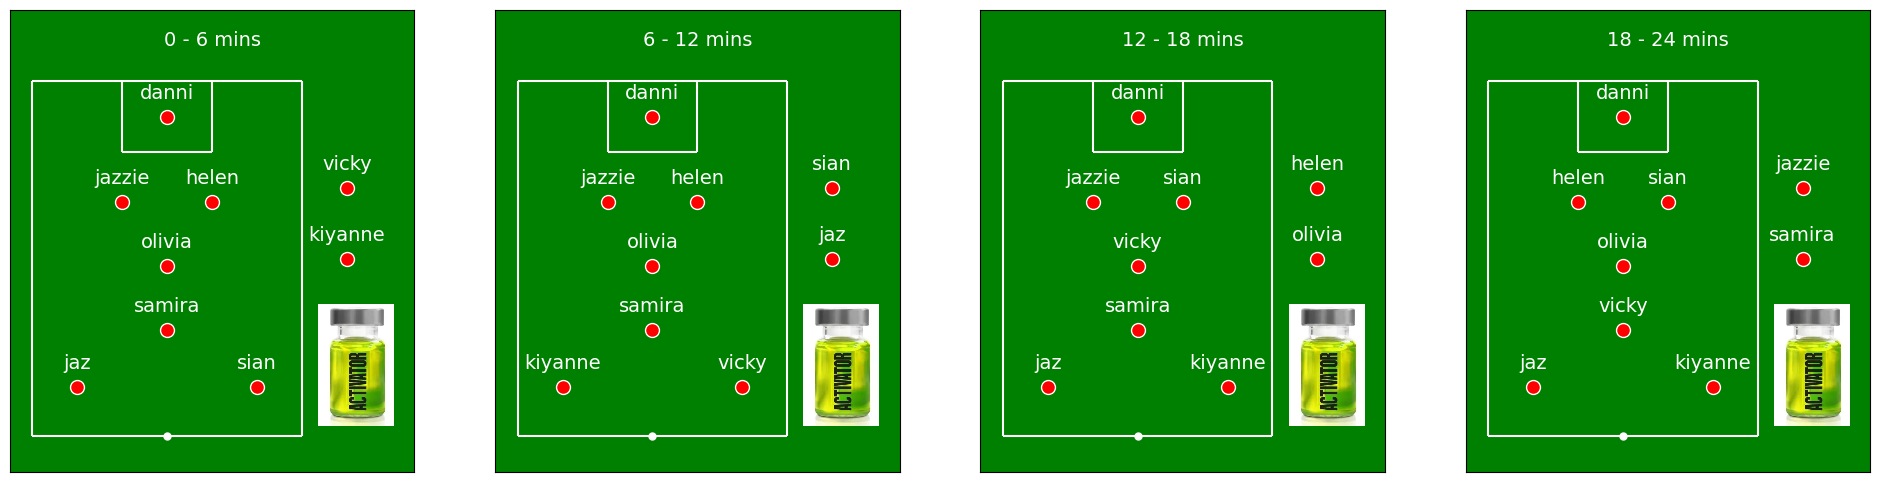

In [78]:
plot_formations(for_display, 0, 25)

In [15]:
for_display_modified = [['jen', 'helen', 'sian', 'mychelle', 'keah', 'jaz', 'ella', 'vicky', 'shafa', 'jess'],
['jen', 'helen', 'jess', 'vicky', 'shafa', 'jaz', 'ella', 'sian', 'keah', 'mychelle'],
                        ['jen', 'sian', 'jess', 'vicky', 'keah', 'mychelle', 'shafa', 'jaz', 'helen', 'ella']]

In [16]:
for_display_modified = []
for_display_modified.append(for_display[0])
for_display_modified.append(for_display[1])
for_display_modified.append(for_display[2])

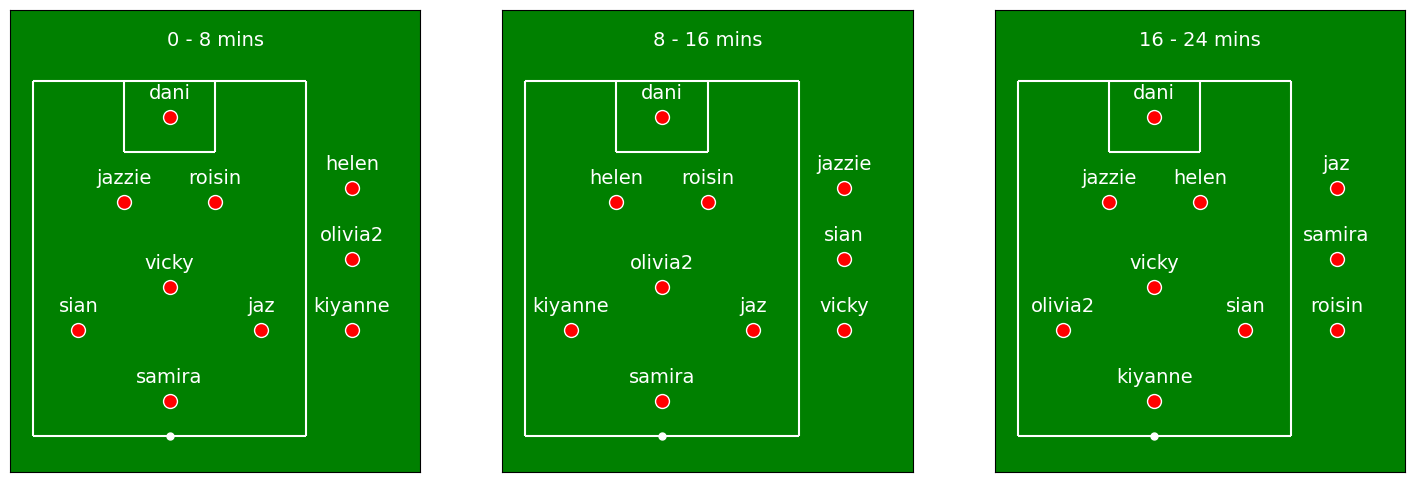

In [17]:
plot_formations(for_display_modified, 0, 25)

In [54]:
def get_rota_for_player(player_name, rota, formation=formation):
    player_positions = []
    for period in rota:
        i = period.index(player_name)
        if i < len(formation):
            player_positions.append(formation[i])
        else:
            player_positions.append('sub')
    print(f'{player_name}: ', ', '.join(player_positions))

In [55]:
for player in this_week:
    get_rota_for_player(player, for_display)

danni:  G, G, G, G
jazzie:  D, D, D, sub
helen:  D, D, sub, D
sian:  RW, sub, D, D
vicky:  sub, RW, DCM, ACM
jaz:  LW, sub, LW, LW
samira:  ACM, ACM, ACM, sub
olivia:  DCM, DCM, sub, DCM
kiyanne:  sub, LW, RW, RW
